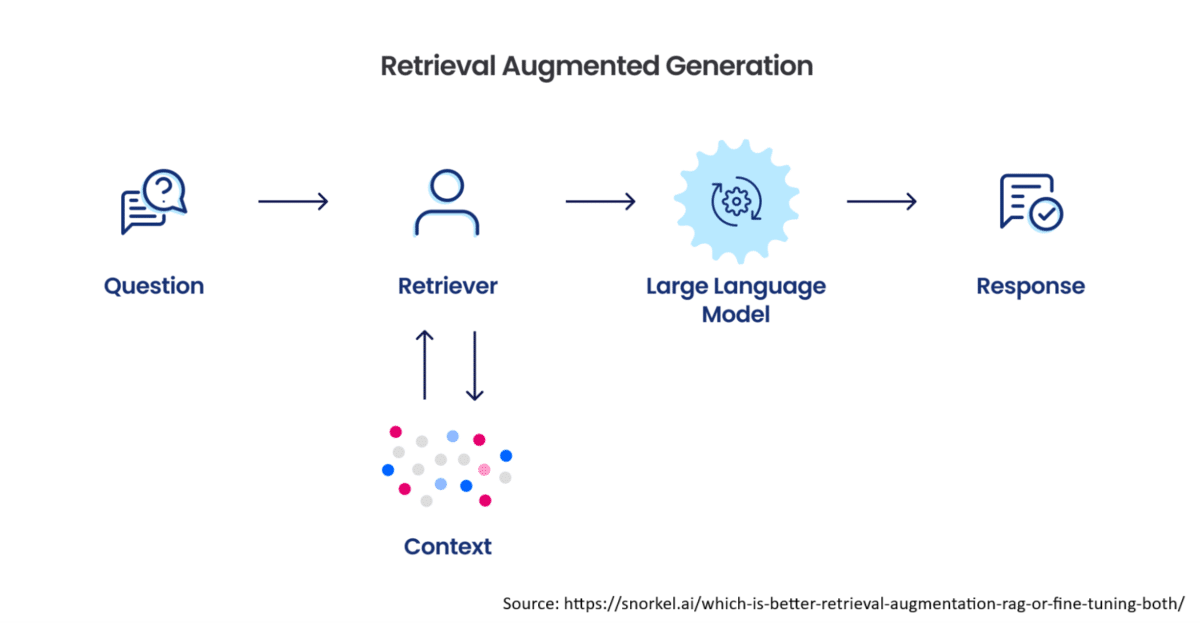

### Loading Data
* The PDF document is first loaded using `PDFReader`.
* Large documents are divided into smaller, manageable chunks using text splitters. This facilitates easier indexing and ensures the data can fit within the model's context window for processing.
* These chunks are then stored and indexed using a `VectorStore` and an embeddings model, enabling efficient search later.

### Retrieval and Generation
* When a query is received, relevant chunks are retrieved from storage using a `Retriever`.
* A `ChatModel` or `LLM` generates a response by using a prompt that incorporates both the user's question and the retrieved content.

In [1]:
# Upgrade pip
!pip install -q -U pip

# Install compatible PyTorch (CPU version for Colab by default; remove --index-url for GPU)
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Install compatible Hugging Face stack
!pip install -q transformers==4.36.2 tokenizers==0.15.2

# LangChain ecosystem (latest stable)
!pip install -q langchain langchain-community langchain-text-splitters langchain-huggingface

# Embeddings and vector storage
!pip install -q sentence-transformers==2.2.2 faiss-cpu

# Document processing
!pip install -q python-docx python-pptx PyPDF2

# Utility
!pip install -q nltk

# Install compatible Hugging Face Hub
!pip install -q huggingface-hub==0.25.2

from IPython.display import clear_output
clear_output()  # For a cleaner notebook

In [2]:
# necessary Imports
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

from docx import Document
from PyPDF2 import PdfReader
from pptx import Presentation
from langchain_community.llms import Cohere
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage, HumanMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder

from sentence_transformers import SentenceTransformer, util
import nltk, os

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


## Loading PDF

In [3]:
!wget -O Practical_Machine_Learning.pdf "https://raw.githubusercontent.com/sahil-5252/rag-qa/refs/heads/main/Practical_Machine_Learning.pdf"
pdf_file = open('Practical_Machine_Learning.pdf', 'rb')

--2025-07-22 06:44:57--  https://raw.githubusercontent.com/sahil-5252/rag-qa/refs/heads/main/Practical_Machine_Learning.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14875595 (14M) [application/octet-stream]
Saving to: ‘Practical_Machine_Learning.pdf’

Practical_Machine_L 100%[===================>]  14.19M  --.-KB/s    in 0.1s    

2025-07-22 06:44:57 (118 MB/s) - ‘Practical_Machine_Learning.pdf’ saved [14875595/14875595]



In [4]:
import PyPDF2
from PyPDF2 import PdfReader

# extracting pdf data
pdf_text = ""
pdf_reader = PdfReader(pdf_file)
for page in pdf_reader.pages:
    pdf_text += page.extract_text()

In [5]:
# merging all the text
all_text = pdf_text
len(all_text)

444749

## Chunking

In [6]:
# splitting the text into chunks for embeddings creation

text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 1000,
        chunk_overlap = 200, # This is helpul to handle the data loss while chunking.
        length_function = len,
        separators=['\n', '\n\n', ' ', '']
    )

chunks = text_splitter.split_text(text = all_text)

In [7]:
len(chunks)

558

In [8]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

os.environ['HuggingFaceHub_API_Token']= HF_TOKEN

## Creating Embeddings

In [9]:
# Initializing embeddings model

embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


## Indexing

In [10]:
# Indexing the data using FAISS
vectorstore = FAISS.from_texts(chunks, embedding = embeddings)

### Retriever
The retriever utilizes the pre-indexed embeddings of document chunks, searching through them to find the most relevant pieces of content in response to a user query. This process involves setting up a retrieval mechanism that leverages similarity search to identify the best matches for the query embeddings within the indexed data.

In [11]:
# creating retriever
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

In [12]:
retrieved_docs = retriever.invoke("Some CPUs provide for more than two modes of operation. What are two possible uses of these multiple modes?")

In [13]:
len(retrieved_docs)

6

In [14]:
# Example of excerpt of document
print(retrieved_docs[0].page_content)

number of available cores. A minimum recommendation for simple machine learning 
tasks would be a dual- core 2.2 GHz processor.
5.13.2 GPU
A GPU, or Graphics Processing Unit, is a specialized microprocessing chip or circuit 
for graphics- related tasks. GPUs are widely used in machine learning due to their ability 
to efficiently perform parallel computations, surpassing the capabilities of CPUs in this 
regard. They feature a large number of cores and high memory bandwidth, making them 
well- suited for parallel processing of large datasets. Several types of GPUs are available 
in the market, including Tesla NVIDIA, NVIDIA GeForce RTX, NVIDIA Quadro RTX, 
and AMD Radeon RX.
5.13.3 TPU
The Tensor Processing Unit (TPU) is a custom- designed application- specific integrated 
circuit (ASIC) developed by Google. It is specifically designed to accelerate machine 
learning tasks, particularly for training and inference of large AI models. TPUs are opti -


In [15]:
# function to create a single string of relevant documents given by Faiss
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## Importing LLM

In [16]:
# Create a tokenizer object by loading the pretrained "Intel/dynamic_tinybert" tokenizer
tokenizer = AutoTokenizer.from_pretrained("Intel/dynamic_tinybert")

# Create a question-answering model object by loading the pretrained "Intel/dynamic_tinybert" model
model = AutoModelForQuestionAnswering.from_pretrained("Intel/dynamic_tinybert")

model_name = "Intel/dynamic_tinybert"

# Load the tokenizer associated with the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, truncation=True, max_length=512)

# Define a question-answering pipeline using the model and tokenizer
hf_pipeline = pipeline(
    "question-answering",
    model=model_name,
    tokenizer=tokenizer,
    return_tensors='pt'
)

# Create an instance of the HuggingFacePipeline, which wraps the question-answering pipeline
# with additional model-specific arguments (temperature and max_length)
hf_llm = HuggingFacePipeline(
    pipeline=hf_pipeline,
    model_kwargs={"temperature": 0.2, "max_length": 512}, # set low temperature to suppress hallucinations
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipython-input-16-3241350460.py:22: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  hf_llm = HuggingFacePipeline(


In [17]:
# Create a question-answering instance (qa) using the RetrievalQA class
# configured with a language model (llm), a chain type "refine", the retriever, and an option to not return source documents
qa = RetrievalQA.from_chain_type(
    llm=hf_llm,
    chain_type="refine",
    retriever=retriever,
    return_source_documents=False
)

In [18]:
nltk.download('punkt')
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# function to extract relevant text from the excerpt
def extract_relevant_sentences(question, docs, top_n=3):
    sentences = []
    for doc in docs:
        sentences.extend(nltk.sent_tokenize(doc.page_content))

    # Encode all sentences and the question
    question_embedding = embedder.encode(question, convert_to_tensor=True)
    sentence_embeddings = embedder.encode(sentences, convert_to_tensor=True)

    # Compute cosine similarities
    similarities = util.cos_sim(question_embedding, sentence_embeddings)[0]

    # Get top N sentences
    top_indices = similarities.argsort(descending=True)[:top_n]
    top_sentences = [sentences[i] for i in top_indices]

    return " ".join(top_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Results

In [19]:
import nltk
nltk.download('punkt_tab')

def answer_with_context(question, top_k=1):
    # retrieve relevant context
    docs = retriever.get_relevant_documents(question)
    relevant_docs = docs[:top_k]
    context_text = extract_relevant_sentences(question, relevant_docs, top_n=2)

    # feed the context and question to the QA model
    qa_input = {
        "question": question,
        "context": context_text
    }
    result = hf_pipeline(qa_input)
    answer = result["answer"]
    score = result["score"]

    # add custom fallback if answer seems empty or unconfident
    if score < 0.4:
        return {
            "answer": "answer not available in context",
            "context": "None available"
        }

    # return both the answer and context
    return {
        "answer": answer,
        "context": context_text
    }

# example usage
response = answer_with_context(
    question="What is Machine Learning?",
    top_k=3
)

print("Answer:", response["answer"], "\nRelevant Context:\n", response["context"])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/tmp/ipython-input-19-2309308351.py:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


Answer: a field of science 
Relevant Context:
 Machine learning is a field of science that utilizes data and algorithms to train  computers On the other hand, machine learning is a specialized field within data 
science that focuses on comprehending and constructing models that leverage data to 
enhance performance or make predictions.


In [20]:
response = answer_with_context(
    question="Why is the color of the sky blue?",
    top_k=3
)

print("Answer:", response["answer"], "\nRelevant Context:\n", response["context"])

Answer: answer not available in context 
Relevant Context:
 None available


In [21]:
response = answer_with_context(
    question="What are the ethical considerations surrounding machine learning?",
    top_k=3
)

print("Answer:", response["answer"], "\nRelevant Context:\n", response["context"])

Answer: DESCRIPTION
Bias and Discrimination 
Relevant Context:
 Table 6.2  summarizes the general ethical issues of machine learning.142 Practical Machine Learning
TABLE 6.2 Ethical implications of machine learning
CONCERN DESCRIPTION
Bias and Discrimination Machine learning models may unintentionally perpetuate 
bias and discrimination contained in the training data. Notably, the ethical dimension of machine learning cannot be 
overstated.


In [22]:
response = answer_with_context(
    question="What are crucial aspects of general intelligence?",
    top_k=3
)

print("Answer:", response["answer"], "\nRelevant Context:\n", response["context"])

Answer: analogy and abstraction 
Relevant Context:
 7.2 WHAT MAKES AN 
INTELLIGENCE GENERAL? Moreover, 
analogy and abstraction are also essential aspects of general intelligence.
